*Mounting Gdrive*

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


*Process to retrieve Kaggle dataset in colab notebook via Gdrive*

In [2]:
!pip install kaggle

In [3]:
# Change the current working directory where you want to download the kaggle dataset
%cd /content/gdrive/MyDrive/Kaggle/        

/content/gdrive/MyDrive/Kaggle


In [4]:
# Run the following code to configure the path to “kaggle.json”
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/gdrive/MyDrive/Kaggle/'

In [5]:
# Downloading dataset
!kaggle datasets download -d mahmoudreda55/satellite-image-classification

 23% 5.00M/21.8M [00:00<00:03, 5.27MB/s]
100% 21.8M/21.8M [00:01<00:00, 21.3MB/s]


In [6]:
# Creating a new directory on colab
!mkdir /content/dataset

In [7]:
# Unzip dataset
!unzip -q /content/gdrive/MyDrive/Kaggle/satellite-image-classification.zip -d /content/dataset

In [2]:
! pip install timm

     |████████████████████████████████| 431 kB 4.3 MB/s 


In [3]:
! nvidia-smi

Sat May 21 10:38:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [24]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models
from tqdm import tqdm
import time
import copy
import timm
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device='cpu'
device
print(f"Setup complete. Using torch : {torch.__version__} and torchvision : {torchvision.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch : 1.11.0+cu113 and torchvision : 0.12.0+cu113 (Tesla K80)


In [5]:
# root_path of dataset
ROOT_PATH= '/content/gdrive/MyDrive/Kaggle/satellite-image-classification'

In [6]:
train_dir=os.path.join(ROOT_PATH, 'train')

train_cloudy_dir=os.path.join(train_dir, 'cloudy')
train_desert_dir=os.path.join(train_dir, 'desert')
train_green_area_dir=os.path.join(train_dir, 'green_area')
train_water_dir=os.path.join(train_dir, 'water')

train_cloudy_fnames=os.listdir(train_cloudy_dir)
train_desert_fnames=os.listdir(train_desert_dir)
train_green_area_fnames=os.listdir(train_green_area_dir)
train_water_fnames=os.listdir(train_water_dir)

print(train_cloudy_fnames[:20])
print(train_desert_fnames[:20])
print(train_green_area_fnames[:20])
print(train_water_fnames[:20])

['train_10173.jpg', 'train_10070.jpg', 'train_10166.jpg', 'train_10096.jpg', 'train_10021.jpg', 'train_101.jpg', 'train_10081.jpg', 'train_10043.jpg', 'train_10128.jpg', 'train_10581.jpg', 'train_10231.jpg', 'train_10621.jpg', 'train_10609.jpg', 'train_10538.jpg', 'train_10177.jpg', 'train_10406.jpg', 'train_10265.jpg', 'train_10201.jpg', 'train_10326.jpg', 'train_10225.jpg']
['desert(1).jpg', 'desert(100).jpg', 'desert(101) (1).jpg', 'desert(101).jpg', 'desert(10).jpg', 'desert(104).jpg', 'desert(103).jpg', 'desert(102).jpg', 'desert(107).jpg', 'desert(106).jpg', 'desert(105).jpg', 'desert(114).jpg', 'desert(11).jpg', 'desert(119).jpg', 'desert(112).jpg', 'desert(12).jpg', 'desert(118).jpg', 'desert(109).jpg', 'desert(120).jpg', 'desert(113).jpg']
['Forest_1404.jpg', 'Forest_1470.jpg', 'Forest_1691.jpg', 'Forest_1464.jpg', 'Forest_1480.jpg', 'Forest_1638.jpg', 'Forest_1731.jpg', 'Forest_1456.jpg', 'Forest_1419.jpg', 'Forest_1479.jpg', 'Forest_1488.jpg', 'Forest_1763.jpg', 'Forest_1591

In [7]:
nrows=6
ncols=4
pic_index=0 # Index for iterating over images
fig=plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
cloudy_img_path_list= [os.path.join(train_cloudy_dir, fname) for fname in train_cloudy_fnames[pic_index-8:pic_index]]
print('cloudy_img_path_list', cloudy_img_path_list)

desert_img_path_list= [os.path.join(train_desert_dir, fname) for fname in train_desert_fnames[pic_index-8:pic_index]]
print('desert_img_path_list', desert_img_path_list)

green_area_img_path_list= [os.path.join(train_green_area_dir, fname) for fname in train_green_area_fnames[pic_index-8:pic_index]]
print('green_area_img_path_list', green_area_img_path_list)

water_img_path_list=[os.path.join(train_water_dir, fname) for fname in train_water_fnames[pic_index-8:pic_index]]
print('water_img_path_list', water_img_path_list)

for i, img_path in enumerate(cloudy_img_path_list+desert_img_path_list+green_area_img_path_list+water_img_path_list):
  # Set up subplot: subplot indices start at 1
  sp=plt.subplot(nrows, ncols, i+1)
  sp.axis('off') # Don't show axis (or gridlines)
  img=mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

cloudy_img_path_list []
desert_img_path_list []
green_area_img_path_list []
water_img_path_list []


<Figure size 1152x1728 with 0 Axes>

**Dataset Loader Function with different Augmentations**

In [8]:
def get_dataset_loader(data_path, batch_size=256, train=False):
  if train:
    transform= transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomVerticalFlip(p=0.5), 
    transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(), transforms.GaussianBlur(3)]), p=0.1), 
    transforms.Resize(256), 
    transforms.CenterCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.466), (0.229, 0.224, 0.255)), 
    transforms.RandomErasing(p=0.12, value='random')])
    # Normalize input[channel]= (input[channel]-mean[channel])/std[channel]
    
    train_imgs=datasets.ImageFolder(os.path.join(ROOT_PATH, 'train/'), transform=transform)
    print(f'We have {len(train_imgs)} Training images with {len(train_imgs.classes)} classes.')
    len_train_images= int(len(train_imgs)*0.9)
    len_val_images= int(len(train_imgs)-len_train_images)
    train_dataset, val_dataset=random_split(train_imgs, [len_train_images, len_val_images])
    train_dataloader= DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_dataloader= DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    return train_dataloader, val_dataloader, len(train_dataset), len(val_dataset)
  else:
    transform= transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.466), (0.229, 0.224, 0.255))                              
    ])
    test_imgs=datasets.ImageFolder(os.path.join(ROOT_PATH, 'test/'), transform=transform)
    print(f'We have {len(test_imgs)} Testing images with {len(test_imgs.classes)} classes.')
    test_dataloader=DataLoader(test_imgs, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    return test_dataloader, len(test_imgs)

*Get number of classes*

In [9]:
class_categories=datasets.ImageFolder(os.path.join(ROOT_PATH, 'train/')).classes
# ['cloudy', 'desert', 'green_area', 'water']
num_classes=len(class_categories)
num_classes

4

*Displaying a random Image*

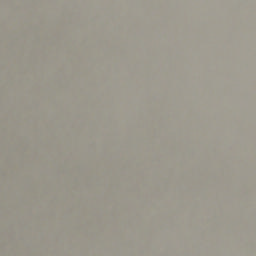

In [14]:
train_data=datasets.ImageFolder(os.path.join(ROOT_PATH, 'train/'))
train_data[3][0]

*Invoke the get_dataset_loader() function to get all loaders (train, test, val)*

In [15]:
BATCH_SIZE=32
(train_dataloader, val_dataloader, len_train_dataloader, len_val_dataloader)= get_dataset_loader(ROOT_PATH, batch_size=BATCH_SIZE, train=True)
(test_dataloader, len_test_dataloader)=get_dataset_loader(ROOT_PATH, batch_size=BATCH_SIZE, train=False)

We have 4000 Training images with 4 classes.
We have 1631 Testing images with 4 classes.


In [16]:
train_dataloader.dataset

In [17]:
test_dataloader.dataset

Dataset ImageFolder
    Number of datapoints: 1631
    Root location: /content/gdrive/MyDrive/Kaggle/satellite-image-classification/test/
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.466), std=(0.229, 0.224, 0.255))
           )

In [18]:
print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))
print(len_train_dataloader, len_val_dataloader, len_test_dataloader)

113
13
51
3600 400 1631


In [19]:
dataloaders_dict={'train': train_dataloader, 'val': val_dataloader}
dataset_sizes_dict={'train':len_train_dataloader, 'val': len_val_dataloader}

**Now that all augmentation are applied, Plot some of those images.**

what does next() and iter() do in PyTorch's DataLoader()?

Basically iter() calls the **__iter__()** method on the train_loader.
Now train_dataloader is an iterable or python iterator, and passing it to
iter() returns an iterator which you can iterate through.
so train_dataloader will return elements from our dataset batch by batch. This allows you to use it as for data in train_loader.
next() then call the **__next__()** method on that iterator to get the first iteration.

Running next() again will get the second item of the iterator, etc.
so lets say, I run next() few more times. Each time i run next() will return next batch of size 32 of the iterator until there are no batches left.


```
it=iter(train_dataloader)
first=next(it)
second=next(it)
```









*Check the shape of return inputs and labels from train_dataloader*

In [20]:
for i, (inputs, labels) in enumerate(train_dataloader):
  print(inputs.shape, labels.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

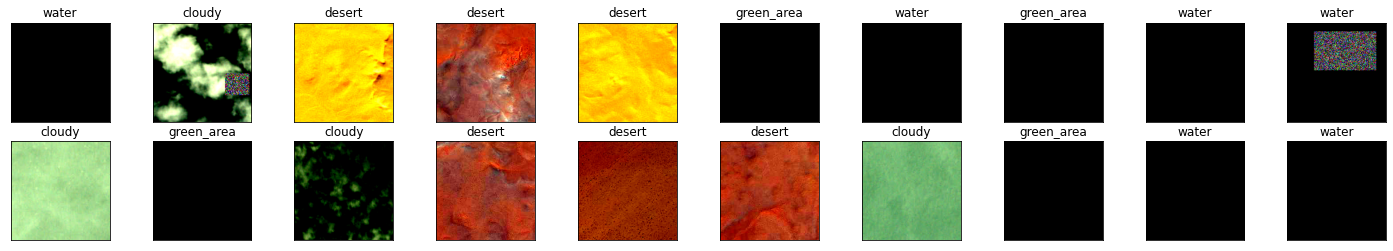

In [23]:
train_loader_iterable=iter(train_dataloader)
images, labels= train_loader_iterable.next()
# Now for displaying, I will have to convert images to Numpy
images=images.numpy()

fig=plt.figure(figsize=(25, 4))
for idx in np.arange(20):
  ax=fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
  '''Dataloader output is a 4 dimensional array i.e. [batch_size, channel, height, width]. But Matplotlib and other image processing libraries 
   require [height, width, channel]. np.transpose() method converts tensor from [channel, height, width] to [height, width, channel] that is (1,2,0)
   is used in plt.imshow() method below.'''
  plt.imshow(np.transpose(images[idx], (1, 2, 0)))
  ax.set_title(class_categories[labels[idx]])

*Load EfficientNet_b0 from torchvision models*

In [25]:
torch.backends.cudnn.benchmark=True
model=models.efficientnet_b0(pretrained=True)
print('model.classifier:', model.classifier)
 
for param in model.parameters():
  param.requires_grad= False
  ''' Dealing with pre-trained model, it is mandatory to set param.requires_grad= False. Freezing 
the computational base before compiling and training the model. It prevents the weights in these 
layer from being updated.
'''
num_inputs=model.classifier[1].in_features
'''
Now here is where I am adding additional layers to the pre-trained model.
for nn.Linear - note the following
in_features - size of each input sample
out_features - size of each output sample
'''
model.classifier= nn.Sequential(
    nn.Linear(num_inputs, 2048),
    nn.SiLU(), # Sigmoid weighted Linear Unit
    nn.Dropout(0.2),
    # Note that the last layer is 2048*Number of classes
    # Reshape the final layer(s) to have the same number of outputs as the number of class of the new dataset
    nn.Linear(2048, len(class_categories))
)
model=model.to(device)
print(model.classifier)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

model.classifier: Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)
Sequential(
  (0): Linear(in_features=1280, out_features=2048, bias=True)
  (1): SiLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=2048, out_features=4, bias=True)
)


In [26]:
'''Since i am dealing with multiclass classificiation problem that is why i
 used cross entropy loss. label smoothing in a nutshell is the way to make the
 model more robust so that it generalizes well. Fundamentally, it solves over
 confidence problem. label_smoothing is used when loss function is cross entropy loss
 and model applies the softmax function to the penaltimate layer logit vector
 to compute its probabilities.
 '''
criterion=nn.CrossEntropyLoss(label_smoothing=0.11)
criterion=criterion.to(device)
optimizer=optim.AdamW(model.classifier.parameters(), lr=0.001)

In [27]:
exp_lr_scheduler=optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.8)
# Change the learning rate based on number of epochs
# Decays the learning rate of each parameter group by gamma every step_size epochs

In [28]:
training_history= {'accuracy':[], 'loss':[]}
val_history= {'accuracy':[], 'loss':[]}

*Training the Model*
    

In [29]:
def train(model, criterion, optimizer, scheduler, num_epochs=65):
  start_time = time.time()
  
  best_model_weights = copy.deepcopy(model.state_dict())
  best_accuracy = 0.0
  
  for epoch in range(num_epochs):
    print('Running epoch {}/{}'.format(epoch, num_epochs-1))
    print('-' * 10)
    
    """ Within each epoch first configure training or eval mode 
    based on wheather I am in the 'train' or 'validation' phase.
    
    `model.train()` tells your model that you are training the model. So effectively layers like dropout, batchnorm etc.
     which behave different on the train and test procedures know what is going on and hence can behave accordingly.
    
    In below, after I start the for loop for phase, the rest entire code for this train() function runs
    within this for loop and at various stage passing the phase variable to be either 'train' or 
    'validation'
    
    """
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0
      
      """ now start the iteration of the dataloaders_dict variable
      i.e. for both 'train' and 'validation' phases 
      
      Below loop, basically tells that, for every epoch the train_dataloader and then the validation_dataloader is invoked
       which returns input and its corresponding label. 
      
      """
      for inputs, labels in tqdm(dataloaders_dict[phase]):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        """ for every mini-batch during the training phase, we typically want to explicitly set the gradients 
        to zero before starting to do backpropragation """
        optimizer.zero_grad()
        
        """ Start the forward movement
        tracking history for phase == 'train' 
        set_grad_enabled is a Context-manager that sets gradient calculation to on or off.

        The argument to it is called mode (which is a boolean ), and this mode controls whether to enable grad (True), 
        or disable (False). This can be used to conditionally enable gradients.
        """
        with torch.set_grad_enabled(phase == 'train'):
          predicted_outputs = model(inputs)          
          # print('outputs on which to apply torch.max ', outputs)
          # find the maximum along the rows, use dim=1 to torch.max()
          _, predictions = torch.max(predicted_outputs, 1)
          
          loss = criterion(predicted_outputs, labels)
          
          # Now for the 'train' phase, do backpropagation and update weights with step()
          if phase == 'train':
            loss.backward()
            optimizer.step()
            
        """ Update the running loss and corrects 
        we need to use, loss.item() instead of loss alone in running_loss calculation and averaging. 
        Because loss gives you a grad_function, not a float value. 
        The item() method extracts the loss’s value as a Python float.
        """
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(predictions == labels.data)
        
      if phase == 'train':
        scheduler.step()      
      
      epoch_loss = running_loss / dataset_sizes_dict[phase]
      epoch_accuracy = running_corrects.double() / dataset_sizes_dict[phase]
      
      """ To summarize, in the above code what I did is
      
      1. => multiply each average batch loss with batch-length. 
      The batch-length is inputs.size(0) which gives the number total images in each batch. 
      Essentially I am un-averaging the Batch-Loss

      Do this all the batches inside the batch-running loop.
      And then after that loop, i.e. outside the batch-loop and coming back to my epoch-loop
      
      2. => Divide this accumulated un-averaged Batch-loss from all batches, 
      by the number of samples (len(train_dataloader)) to get the exact train loss average for the epoch """
      
      
      if phase == 'train':
        training_history['loss'].append(epoch_loss)
        training_history['accuracy'].append(epoch_accuracy)
      elif phase == 'val':
        val_history['loss'].append(epoch_loss)
        val_history['accuracy'].append(epoch_accuracy)
        
      # finally update best_accuracy and deep copy the model
      if phase == 'val' and epoch_accuracy > best_accuracy:
        best_accuracy = epoch_accuracy
        best_model_weights = copy.deepcopy(model.state_dict())
  
  time_elapsed = time.time() - start_time
  print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60
  ))
  print('Best Val Accuracy: {:4f}'.format(best_accuracy))
  
  # loading best model weights
  model.load_state_dict(best_model_weights)
  return model

In [30]:
model_trained= train(model, criterion, optimizer, exp_lr_scheduler, num_epochs=65)

Running epoch 0/64
----------


100%|██████████| 13/13 [01:55<00:00,  8.87s/it]


Running epoch 1/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.75it/s]


Running epoch 2/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.60it/s]


Running epoch 3/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.64it/s]


Running epoch 4/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.41it/s]


Running epoch 5/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.47it/s]


Running epoch 6/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.56it/s]


Running epoch 7/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.66it/s]


Running epoch 8/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.77it/s]


Running epoch 9/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.37it/s]


Running epoch 10/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.74it/s]


Running epoch 11/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.61it/s]


Running epoch 12/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.59it/s]


Running epoch 13/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.68it/s]


Running epoch 14/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.60it/s]


Running epoch 15/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.66it/s]


Running epoch 16/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.64it/s]


Running epoch 17/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.67it/s]


Running epoch 18/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.38it/s]


Running epoch 19/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.69it/s]


Running epoch 20/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.60it/s]


Running epoch 21/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.51it/s]


Running epoch 22/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.52it/s]


Running epoch 23/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.52it/s]


Running epoch 24/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.68it/s]


Running epoch 25/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.58it/s]


Running epoch 26/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.63it/s]


Running epoch 27/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.52it/s]


Running epoch 28/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.52it/s]


Running epoch 29/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.50it/s]


Running epoch 30/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.39it/s]


Running epoch 31/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.38it/s]


Running epoch 32/64
----------


100%|██████████| 13/13 [00:02<00:00,  4.87it/s]


Running epoch 33/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.52it/s]


Running epoch 34/64
----------


100%|██████████| 13/13 [00:03<00:00,  4.32it/s]


Running epoch 35/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.39it/s]


Running epoch 36/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.63it/s]


Running epoch 37/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.64it/s]


Running epoch 38/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.64it/s]


Running epoch 39/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.43it/s]


Running epoch 40/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.47it/s]


Running epoch 41/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.51it/s]


Running epoch 42/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.49it/s]


Running epoch 43/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.50it/s]


Running epoch 44/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.57it/s]


Running epoch 45/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.33it/s]


Running epoch 46/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.59it/s]


Running epoch 47/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.50it/s]


Running epoch 48/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.53it/s]


Running epoch 49/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.63it/s]


Running epoch 50/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.62it/s]


Running epoch 51/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.25it/s]


Running epoch 52/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.54it/s]


Running epoch 53/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.50it/s]


Running epoch 54/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.36it/s]


Running epoch 55/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.62it/s]


Running epoch 56/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.36it/s]


Running epoch 57/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.54it/s]


Running epoch 58/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.29it/s]


Running epoch 59/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.38it/s]


Running epoch 60/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.36it/s]


Running epoch 61/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.55it/s]


Running epoch 62/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.45it/s]


Running epoch 63/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.40it/s]


Running epoch 64/64
----------


100%|██████████| 13/13 [00:02<00:00,  5.38it/s]


Training complete in 25m 31s
Best Val Accuracy: 1.000000


*Final evaluation on the test dataset*

In [31]:
def evaluate(model):
  loss_on_test_dataset= 0.0
  correct_class=list(0. for i in range(len(class_categories)))
  total_correct_for_all_classes=list(0. for i in range(len(class_categories)))

  model.eval()
  for test_inputs, test_labels in tqdm(test_dataloader):
    ''' 
    In local machine, below 2 lines will not work if local GPU itself or
    the GPU's compute capability is not capable with PyTorch.
    '''
    if torch.cuda.is_available():
      test_inputs, test_labels= test_inputs.cuda(), test_labels.cuda()
    with torch.no_grad():
      output_test=model(test_inputs)
      loss=criterion(output_test, test_labels)
    
    loss_on_test_dataset += loss.item()*test_inputs.size(0)
    _, pred_test=torch.max(output_test, 1)

    '''
    Now compare predictions to true label
    view_as: View this tensor as the same size as other.
    self.view_as(other): It is equivalent to self.view(other.size())
    tensor.view_as(other): It is equivalent to tensor.view(other.size())
    '''
    correct_tensor= pred_test.eq(test_labels.view_as(pred_test))
    # Below line of code will make sure if GPU is not available then we copy the tensor to CPU and convert it to numpy array
    correct=np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    if len(test_labels)==BATCH_SIZE:
      for i in range(BATCH_SIZE):
        label=test_labels.data[i]
        # Updating corrects for each class objects
        correct_class[label] += correct[i].item()
        # Updating corrects for total classes
        total_correct_for_all_classes[label] +=1
    loss_on_test_dataset=loss_on_test_dataset/len(test_dataloader.dataset)
    print('Test Loss: {:.6f}\n'.format(loss_on_test_dataset))
    for i in range(len(class_categories)):
      if total_correct_for_all_classes[i]>0:
        # Now print total accuracy % and also number of corrects vs total number
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (class_categories[i], 100*correct_class[i]/total_correct_for_all_classes[i], np.sum(correct_class[i]), np.sum(total_correct_for_all_classes[i])))
      else:
        print('Test Acuuracy of %5s: N?A (no training examples)' %(class_categories[i]))
    print('\n Test Accuracy (overall): {:.4f} ({}/{})'.format(100*np.sum(correct_class)/np.sum(total_correct_for_all_classes), np.sum(correct_class), np.sum(total_correct_for_all_classes)))
                                                                                              

In [32]:
evaluate(model_trained)

  2%|▏         | 1/51 [00:21<17:44, 21.28s/it]

Test Loss: 0.008201

Test Accuracy of cloudy: 100% ( 6/ 6)
Test Accuracy of desert: 100% ( 2/ 2)
Test Accuracy of green_area: 100% (10/10)
Test Accuracy of water: 100% (14/14)

 Test Accuracy (overall): 100.0000 (32.0/32.0)


  4%|▍         | 2/51 [00:23<08:00,  9.81s/it]

Test Loss: 0.007983

Test Accuracy of cloudy: 100% (17/17)
Test Accuracy of desert: 100% ( 7/ 7)
Test Accuracy of green_area: 100% (18/18)
Test Accuracy of water: 100% (22/22)

 Test Accuracy (overall): 100.0000 (64.0/64.0)


  6%|▌         | 3/51 [00:42<11:24, 14.27s/it]

Test Loss: 0.007717

Test Accuracy of cloudy: 100% (27/27)
Test Accuracy of desert: 100% (10/10)
Test Accuracy of green_area: 100% (28/28)
Test Accuracy of water: 100% (31/31)

 Test Accuracy (overall): 100.0000 (96.0/96.0)


  8%|▊         | 4/51 [00:44<07:29,  9.56s/it]

Test Loss: 0.007747

Test Accuracy of cloudy: 100% (40/40)
Test Accuracy of desert: 100% (12/12)
Test Accuracy of green_area: 100% (39/39)
Test Accuracy of water: 100% (37/37)

 Test Accuracy (overall): 100.0000 (128.0/128.0)


 10%|▉         | 5/51 [01:03<09:55, 12.95s/it]

Test Loss: 0.008033

Test Accuracy of cloudy: 100% (54/54)
Test Accuracy of desert: 100% (12/12)
Test Accuracy of green_area: 100% (47/47)
Test Accuracy of water: 100% (47/47)

 Test Accuracy (overall): 100.0000 (160.0/160.0)


 12%|█▏        | 6/51 [01:07<07:14,  9.67s/it]

Test Loss: 0.008329

Test Accuracy of cloudy: 100% (62/62)
Test Accuracy of desert: 100% (16/16)
Test Accuracy of green_area: 100% (57/57)
Test Accuracy of water: 100% (57/57)

 Test Accuracy (overall): 100.0000 (192.0/192.0)


 14%|█▎        | 7/51 [01:25<09:03, 12.36s/it]

Test Loss: 0.007850

Test Accuracy of cloudy: 100% (75/75)
Test Accuracy of desert: 100% (16/16)
Test Accuracy of green_area: 100% (70/70)
Test Accuracy of water: 100% (63/63)

 Test Accuracy (overall): 100.0000 (224.0/224.0)


 16%|█▌        | 8/51 [01:29<07:01,  9.80s/it]

Test Loss: 0.007906

Test Accuracy of cloudy: 100% (87/87)
Test Accuracy of desert: 100% (18/18)
Test Accuracy of green_area: 100% (78/78)
Test Accuracy of water: 100% (73/73)

 Test Accuracy (overall): 100.0000 (256.0/256.0)


 18%|█▊        | 9/51 [01:46<08:23, 11.99s/it]

Test Loss: 0.008845

Test Accuracy of cloudy: 100% (93/93)
Test Accuracy of desert: 100% (19/19)
Test Accuracy of green_area: 100% (89/89)
Test Accuracy of water: 98% (86/87)

 Test Accuracy (overall): 99.6528 (287.0/288.0)


 20%|█▉        | 10/51 [01:51<06:40,  9.77s/it]

Test Loss: 0.008008

Test Accuracy of cloudy: 100% (103/103)
Test Accuracy of desert: 100% (24/24)
Test Accuracy of green_area: 100% (99/99)
Test Accuracy of water: 98% (93/94)

 Test Accuracy (overall): 99.6875 (319.0/320.0)


 22%|██▏       | 11/51 [02:07<07:58, 11.96s/it]

Test Loss: 0.008496

Test Accuracy of cloudy: 100% (110/110)
Test Accuracy of desert: 100% (27/27)
Test Accuracy of green_area: 100% (110/110)
Test Accuracy of water: 99% (104/105)

 Test Accuracy (overall): 99.7159 (351.0/352.0)


 24%|██▎       | 12/51 [02:11<06:10,  9.49s/it]

Test Loss: 0.008030

Test Accuracy of cloudy: 100% (119/119)
Test Accuracy of desert: 100% (28/28)
Test Accuracy of green_area: 100% (122/122)
Test Accuracy of water: 99% (114/115)

 Test Accuracy (overall): 99.7396 (383.0/384.0)


 25%|██▌       | 13/51 [02:30<07:51, 12.40s/it]

Test Loss: 0.007752

Test Accuracy of cloudy: 100% (132/132)
Test Accuracy of desert: 100% (29/29)
Test Accuracy of green_area: 100% (132/132)
Test Accuracy of water: 99% (122/123)

 Test Accuracy (overall): 99.7596 (415.0/416.0)


 27%|██▋       | 14/51 [02:33<05:46,  9.37s/it]

Test Loss: 0.007845

Test Accuracy of cloudy: 100% (139/139)
Test Accuracy of desert: 100% (35/35)
Test Accuracy of green_area: 100% (141/141)
Test Accuracy of water: 99% (132/133)

 Test Accuracy (overall): 99.7768 (447.0/448.0)


 29%|██▉       | 15/51 [02:52<07:21, 12.26s/it]

Test Loss: 0.008136

Test Accuracy of cloudy: 100% (152/152)
Test Accuracy of desert: 100% (37/37)
Test Accuracy of green_area: 100% (150/150)
Test Accuracy of water: 99% (140/141)

 Test Accuracy (overall): 99.7917 (479.0/480.0)


 31%|███▏      | 16/51 [02:56<05:39,  9.71s/it]

Test Loss: 0.008238

Test Accuracy of cloudy: 99% (166/167)
Test Accuracy of desert: 100% (38/38)
Test Accuracy of green_area: 100% (153/153)
Test Accuracy of water: 99% (153/154)

 Test Accuracy (overall): 99.6094 (510.0/512.0)


 33%|███▎      | 17/51 [03:13<06:51, 12.10s/it]

Test Loss: 0.007691

Test Accuracy of cloudy: 99% (179/180)
Test Accuracy of desert: 100% (38/38)
Test Accuracy of green_area: 100% (162/162)
Test Accuracy of water: 99% (163/164)

 Test Accuracy (overall): 99.6324 (542.0/544.0)


 35%|███▌      | 18/51 [03:17<05:18,  9.64s/it]

Test Loss: 0.007938

Test Accuracy of cloudy: 99% (190/191)
Test Accuracy of desert: 100% (38/38)
Test Accuracy of green_area: 100% (171/171)
Test Accuracy of water: 99% (175/176)

 Test Accuracy (overall): 99.6528 (574.0/576.0)


 37%|███▋      | 19/51 [03:35<06:31, 12.22s/it]

Test Loss: 0.008711

Test Accuracy of cloudy: 99% (203/204)
Test Accuracy of desert: 100% (39/39)
Test Accuracy of green_area: 100% (181/181)
Test Accuracy of water: 98% (182/184)

 Test Accuracy (overall): 99.5066 (605.0/608.0)


 39%|███▉      | 20/51 [03:38<04:52,  9.44s/it]

Test Loss: 0.007857

Test Accuracy of cloudy: 99% (213/214)
Test Accuracy of desert: 100% (41/41)
Test Accuracy of green_area: 100% (189/189)
Test Accuracy of water: 98% (194/196)

 Test Accuracy (overall): 99.5312 (637.0/640.0)


 41%|████      | 21/51 [03:56<05:57, 11.93s/it]

Test Loss: 0.008387

Test Accuracy of cloudy: 99% (221/222)
Test Accuracy of desert: 100% (42/42)
Test Accuracy of green_area: 99% (197/198)
Test Accuracy of water: 99% (208/210)

 Test Accuracy (overall): 99.4048 (668.0/672.0)


 43%|████▎     | 22/51 [03:59<04:29,  9.28s/it]

Test Loss: 0.008348

Test Accuracy of cloudy: 99% (230/231)
Test Accuracy of desert: 100% (46/46)
Test Accuracy of green_area: 99% (207/208)
Test Accuracy of water: 99% (217/219)

 Test Accuracy (overall): 99.4318 (700.0/704.0)


 45%|████▌     | 23/51 [04:18<05:41, 12.21s/it]

Test Loss: 0.007809

Test Accuracy of cloudy: 99% (241/242)
Test Accuracy of desert: 100% (49/49)
Test Accuracy of green_area: 99% (211/212)
Test Accuracy of water: 99% (231/233)

 Test Accuracy (overall): 99.4565 (732.0/736.0)


 47%|████▋     | 24/51 [04:20<04:08,  9.21s/it]

Test Loss: 0.007794

Test Accuracy of cloudy: 99% (252/253)
Test Accuracy of desert: 100% (53/53)
Test Accuracy of green_area: 99% (221/222)
Test Accuracy of water: 99% (238/240)

 Test Accuracy (overall): 99.4792 (764.0/768.0)


 49%|████▉     | 25/51 [04:40<05:19, 12.31s/it]

Test Loss: 0.008240

Test Accuracy of cloudy: 99% (261/262)
Test Accuracy of desert: 100% (53/53)
Test Accuracy of green_area: 99% (232/234)
Test Accuracy of water: 99% (249/251)

 Test Accuracy (overall): 99.3750 (795.0/800.0)


 51%|█████     | 26/51 [04:42<03:47,  9.12s/it]

Test Loss: 0.007943

Test Accuracy of cloudy: 99% (270/271)
Test Accuracy of desert: 100% (55/55)
Test Accuracy of green_area: 99% (244/246)
Test Accuracy of water: 99% (258/260)

 Test Accuracy (overall): 99.3990 (827.0/832.0)


 53%|█████▎    | 27/51 [05:01<04:52, 12.17s/it]

Test Loss: 0.007949

Test Accuracy of cloudy: 99% (281/282)
Test Accuracy of desert: 100% (59/59)
Test Accuracy of green_area: 99% (250/252)
Test Accuracy of water: 99% (269/271)

 Test Accuracy (overall): 99.4213 (859.0/864.0)


 55%|█████▍    | 28/51 [05:03<03:33,  9.29s/it]

Test Loss: 0.007997

Test Accuracy of cloudy: 99% (290/291)
Test Accuracy of desert: 100% (60/60)
Test Accuracy of green_area: 99% (259/261)
Test Accuracy of water: 99% (282/284)

 Test Accuracy (overall): 99.4420 (891.0/896.0)


 57%|█████▋    | 29/51 [05:23<04:31, 12.32s/it]

Test Loss: 0.008172

Test Accuracy of cloudy: 99% (302/303)
Test Accuracy of desert: 100% (64/64)
Test Accuracy of green_area: 99% (267/269)
Test Accuracy of water: 99% (290/292)

 Test Accuracy (overall): 99.4612 (923.0/928.0)


 59%|█████▉    | 30/51 [05:24<03:06,  8.87s/it]

Test Loss: 0.007801

Test Accuracy of cloudy: 99% (315/316)
Test Accuracy of desert: 100% (67/67)
Test Accuracy of green_area: 99% (275/277)
Test Accuracy of water: 99% (298/300)

 Test Accuracy (overall): 99.4792 (955.0/960.0)


 63%|██████▎   | 32/51 [05:45<02:48,  8.88s/it]

Test Loss: 0.008041

Test Accuracy of cloudy: 99% (322/323)
Test Accuracy of desert: 100% (71/71)
Test Accuracy of green_area: 99% (280/282)
Test Accuracy of water: 99% (314/316)

 Test Accuracy (overall): 99.4960 (987.0/992.0)
Test Loss: 0.007796

Test Accuracy of cloudy: 99% (330/331)
Test Accuracy of desert: 100% (73/73)
Test Accuracy of green_area: 99% (290/292)
Test Accuracy of water: 99% (326/328)

 Test Accuracy (overall): 99.5117 (1019.0/1024.0)


 65%|██████▍   | 33/51 [06:06<03:44, 12.50s/it]

Test Loss: 0.008491

Test Accuracy of cloudy: 99% (334/336)
Test Accuracy of desert: 100% (78/78)
Test Accuracy of green_area: 99% (303/305)
Test Accuracy of water: 99% (335/337)

 Test Accuracy (overall): 99.4318 (1050.0/1056.0)


 67%|██████▋   | 34/51 [06:08<02:37,  9.27s/it]

Test Loss: 0.008890

Test Accuracy of cloudy: 99% (346/348)
Test Accuracy of desert: 100% (81/81)
Test Accuracy of green_area: 99% (308/311)
Test Accuracy of water: 99% (346/348)

 Test Accuracy (overall): 99.3566 (1081.0/1088.0)


 69%|██████▊   | 35/51 [06:27<03:15, 12.24s/it]

Test Loss: 0.007804

Test Accuracy of cloudy: 99% (352/354)
Test Accuracy of desert: 100% (85/85)
Test Accuracy of green_area: 99% (319/322)
Test Accuracy of water: 99% (357/359)

 Test Accuracy (overall): 99.3750 (1113.0/1120.0)


 71%|███████   | 36/51 [06:30<02:21,  9.46s/it]

Test Loss: 0.011836

Test Accuracy of cloudy: 99% (362/365)
Test Accuracy of desert: 100% (87/87)
Test Accuracy of green_area: 99% (328/331)
Test Accuracy of water: 99% (367/369)

 Test Accuracy (overall): 99.3056 (1144.0/1152.0)


 73%|███████▎  | 37/51 [06:48<02:47, 11.94s/it]

Test Loss: 0.007836

Test Accuracy of cloudy: 99% (371/374)
Test Accuracy of desert: 100% (88/88)
Test Accuracy of green_area: 99% (342/345)
Test Accuracy of water: 99% (375/377)

 Test Accuracy (overall): 99.3243 (1176.0/1184.0)


 75%|███████▍  | 38/51 [06:52<02:05,  9.69s/it]

Test Loss: 0.007754

Test Accuracy of cloudy: 99% (383/386)
Test Accuracy of desert: 100% (90/90)
Test Accuracy of green_area: 99% (348/351)
Test Accuracy of water: 99% (387/389)

 Test Accuracy (overall): 99.3421 (1208.0/1216.0)


 76%|███████▋  | 39/51 [07:09<02:21, 11.81s/it]

Test Loss: 0.007870

Test Accuracy of cloudy: 99% (391/394)
Test Accuracy of desert: 100% (92/92)
Test Accuracy of green_area: 99% (361/364)
Test Accuracy of water: 99% (396/398)

 Test Accuracy (overall): 99.3590 (1240.0/1248.0)


 78%|███████▊  | 40/51 [07:13<01:45,  9.57s/it]

Test Loss: 0.007956

Test Accuracy of cloudy: 99% (399/402)
Test Accuracy of desert: 100% (96/96)
Test Accuracy of green_area: 99% (378/381)
Test Accuracy of water: 99% (399/401)

 Test Accuracy (overall): 99.3750 (1272.0/1280.0)


 80%|████████  | 41/51 [07:30<01:56, 11.67s/it]

Test Loss: 0.007767

Test Accuracy of cloudy: 99% (407/410)
Test Accuracy of desert: 100% (97/97)
Test Accuracy of green_area: 99% (391/394)
Test Accuracy of water: 99% (409/411)

 Test Accuracy (overall): 99.3902 (1304.0/1312.0)


 82%|████████▏ | 42/51 [07:34<01:24,  9.38s/it]

Test Loss: 0.008245

Test Accuracy of cloudy: 99% (418/421)
Test Accuracy of desert: 100% (98/98)
Test Accuracy of green_area: 99% (405/408)
Test Accuracy of water: 99% (415/417)

 Test Accuracy (overall): 99.4048 (1336.0/1344.0)


 84%|████████▍ | 43/51 [07:52<01:35, 11.88s/it]

Test Loss: 0.008097

Test Accuracy of cloudy: 99% (429/432)
Test Accuracy of desert: 100% (101/101)
Test Accuracy of green_area: 99% (413/416)
Test Accuracy of water: 99% (425/427)

 Test Accuracy (overall): 99.4186 (1368.0/1376.0)


 86%|████████▋ | 44/51 [07:54<01:04,  9.18s/it]

Test Loss: 0.007946

Test Accuracy of cloudy: 99% (438/441)
Test Accuracy of desert: 100% (103/103)
Test Accuracy of green_area: 99% (424/427)
Test Accuracy of water: 99% (435/437)

 Test Accuracy (overall): 99.4318 (1400.0/1408.0)


 88%|████████▊ | 45/51 [08:13<01:11, 11.97s/it]

Test Loss: 0.007954

Test Accuracy of cloudy: 99% (449/452)
Test Accuracy of desert: 100% (107/107)
Test Accuracy of green_area: 99% (435/438)
Test Accuracy of water: 99% (441/443)

 Test Accuracy (overall): 99.4444 (1432.0/1440.0)


 90%|█████████ | 46/51 [08:17<00:48,  9.62s/it]

Test Loss: 0.007834

Test Accuracy of cloudy: 99% (453/456)
Test Accuracy of desert: 100% (112/112)
Test Accuracy of green_area: 99% (444/447)
Test Accuracy of water: 99% (455/457)

 Test Accuracy (overall): 99.4565 (1464.0/1472.0)


 92%|█████████▏| 47/51 [08:34<00:46, 11.71s/it]

Test Loss: 0.008947

Test Accuracy of cloudy: 99% (464/468)
Test Accuracy of desert: 100% (115/115)
Test Accuracy of green_area: 99% (454/457)
Test Accuracy of water: 99% (462/464)

 Test Accuracy (overall): 99.4016 (1495.0/1504.0)


 94%|█████████▍| 48/51 [08:39<00:29,  9.81s/it]

Test Loss: 0.007721

Test Accuracy of cloudy: 99% (472/476)
Test Accuracy of desert: 100% (122/122)
Test Accuracy of green_area: 99% (464/467)
Test Accuracy of water: 99% (469/471)

 Test Accuracy (overall): 99.4141 (1527.0/1536.0)


 96%|█████████▌| 49/51 [08:56<00:23, 11.96s/it]

Test Loss: 0.007624

Test Accuracy of cloudy: 99% (478/482)
Test Accuracy of desert: 100% (125/125)
Test Accuracy of green_area: 99% (476/479)
Test Accuracy of water: 99% (480/482)

 Test Accuracy (overall): 99.4260 (1559.0/1568.0)


 98%|█████████▊| 50/51 [09:01<00:09,  9.71s/it]

Test Loss: 0.007776

Test Accuracy of cloudy: 99% (487/491)
Test Accuracy of desert: 100% (125/125)
Test Accuracy of green_area: 99% (488/491)
Test Accuracy of water: 99% (491/493)

 Test Accuracy (overall): 99.4375 (1591.0/1600.0)


100%|██████████| 51/51 [09:17<00:00, 10.93s/it]

Test Loss: 0.007662

Test Accuracy of cloudy: 99% (487/491)
Test Accuracy of desert: 100% (125/125)
Test Accuracy of green_area: 99% (488/491)
Test Accuracy of water: 99% (491/493)

 Test Accuracy (overall): 99.4375 (1591.0/1600.0)


In [34]:
torch.save(model_trained, '/content/gdrive/MyDrive/Kaggle/satellite.pth' )